# Gradient Boosting Trees

In this notebook, we'll take a look at using boosing to improve model predictions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [20]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


We'll use the same data generation process that we have been using.

In [3]:
def generateData(size = 50, sigma = 0.2, random_state = None):
    if random_state:
        np.random.seed(random_state)
    
    x1 = np.random.uniform(low = 0, high = 1, size = size)
    x2 = np.random.uniform(low = 0, high = 1, size = size)
    y = np.sin(2*np.pi*x1) + np.cos(2*np.pi*x2) + np.random.normal(loc = 0, scale = sigma, size = size)
    
    X = np.c_[x1, x2]
    
    return X, y

In [4]:
X, y = generateData(size = 50, random_state = 321)
X_eval, y_eval = generateData(size = 10000)

C:\Users\alvin\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


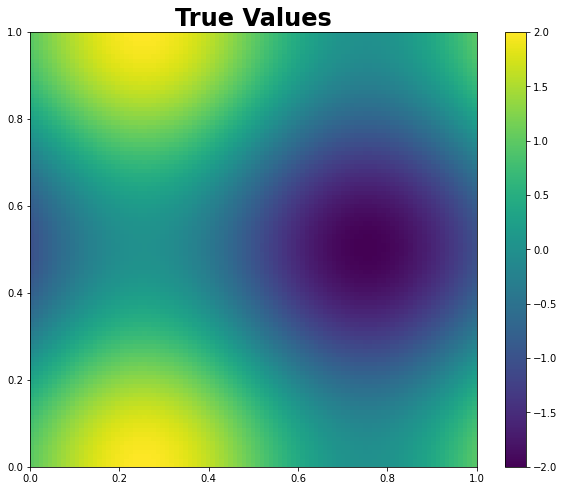

In [5]:
plt.figure(figsize = (10,8))

u = np.linspace(0, 1, 100)
v = np.linspace(0, 1, 100)
U,V = np.meshgrid(u, v)
Z = np.sin(2*np.pi*U) + np.cos(2*np.pi*V)
plt.pcolor(U, V, Z, vmin = -2, vmax = 2)
plt.colorbar()
plt.title('True Values', fontsize = 24, fontweight = 'bold')
cm = plt.get_cmap();

In this notebook, we'll be predicting using the simplest decision trees possible - ones that only split the dataset once.

In [6]:
dt = DecisionTreeRegressor(max_depth = 1).fit(X, y)

In [7]:
mean_squared_error(y, dt.predict(X))

0.5003500808583111

In [8]:
mean_squared_error(y_eval, dt.predict(X_eval))

0.6648262330686256

C:\Users\alvin\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


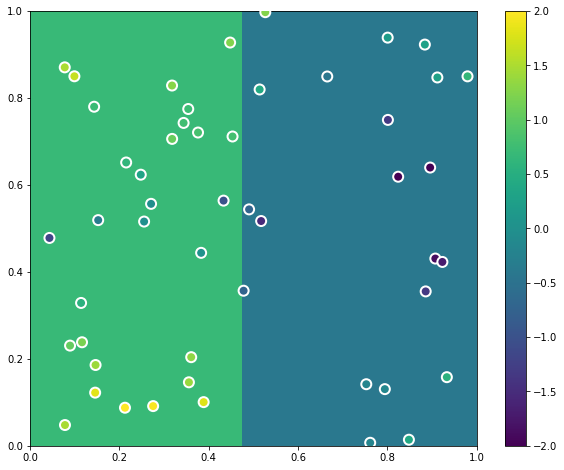

In [9]:
Z = dt.predict(np.array([U.ravel(), V.ravel()]).T)
Z = Z.reshape(U.shape)

fig, ax = plt.subplots(figsize = (10,8))

plt.pcolor(U, V, Z, vmin = -2, vmax = 2)
plt.colorbar()

cm = plt.get_cmap()
plt.scatter(X[:,0], X[:,1], edgecolor = 'white', linewidth = 2,
            s = 100, c = y, cmap = cm, zorder = 100);

By itself, this model is a very poor predictor. But, let's see what happens when we apply graident boosing.

First, we'll build a simple model with no shrinkage.

In [10]:
class BoostedTreeRegressor():
    def __init__(self, num_trees = 100):
        self.num_trees = num_trees
    
    def fit(self, X, y):
        self.trees_ = []
        
        dt = DecisionTreeRegressor(max_depth = 1).fit(X, y)
        self.trees_.append(dt)
        
        resid = y - dt.predict(X)
        
        for _ in range(self.num_trees - 1):            
            dt = DecisionTreeRegressor(max_depth = 1).fit(X, resid)
            self.trees_.append(dt)
            resid = resid - dt.predict(X)
            
        return self
        
    def predict(self, X):
        predictions = self.trees_[0].predict(X) + np.array([dt.predict(X) for dt in self.trees_[1:]]).sum(axis = 0)
        return predictions

In [11]:
bt = BoostedTreeRegressor(num_trees = 100).fit(X, y)

In [12]:
mean_squared_error(y, bt.predict(X))

0.010044215056507311

In [13]:
mean_squared_error(y_eval, bt.predict(X_eval))

0.13024594750363727

With 100 rounds of boosting, we get a significantly better mean squared error. We could try adding additional rounds of boosing.

In [14]:
bt = BoostedTreeRegressor(num_trees = 1000).fit(X, y)

In [15]:
mean_squared_error(y, bt.predict(X))

7.839814258166693e-06

In [16]:
mean_squared_error(y_eval, bt.predict(X_eval))

0.1283320352677273

C:\Users\alvin\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


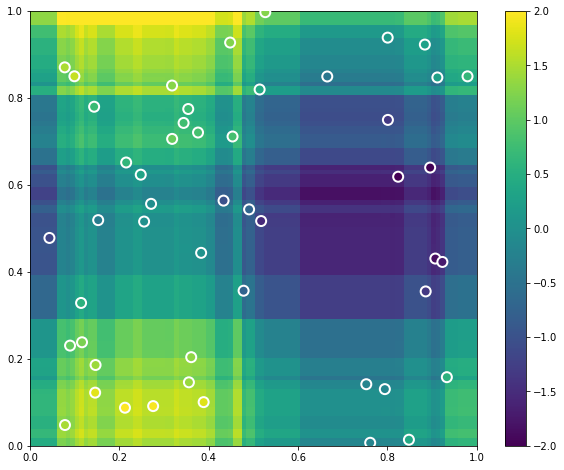

In [17]:
Z = bt.predict(np.array([U.ravel(), V.ravel()]).T)
Z = Z.reshape(U.shape)

fig, ax = plt.subplots(figsize = (10,8))

plt.pcolor(U, V, Z, vmin = -2, vmax = 2)
plt.colorbar()

cm = plt.get_cmap()
plt.scatter(X[:,0], X[:,1], edgecolor = 'white', linewidth = 2,
            s = 100, c = y, cmap = cm, zorder = 100);

Let's add a learning_rate parameter so that we can slow down the boosting process.

In [6]:
class BoostedTreeRegressor():
    def __init__(self, num_trees = 100, learning_rate = 0.1):
        self.num_trees = num_trees
        self.learning_rate = learning_rate
    
    def fit(self, X, y):
        self.trees_ = []
        
        dt = DecisionTreeRegressor(max_depth = 1).fit(X, y)
        self.trees_.append(dt)
        
        resid = y - dt.predict(X)
        
        for _ in range(self.num_trees - 1):            
            dt = DecisionTreeRegressor(max_depth = 1).fit(X, resid)
            self.trees_.append(dt)
            resid = resid - self.learning_rate * dt.predict(X)
            
        return self
        
    def predict(self, X):
        predictions = self.trees_[0].predict(X) + self.learning_rate*np.array([dt.predict(X) for dt in self.trees_[1:]]).sum(axis = 0)
        return predictions

In [19]:
bt = BoostedTreeRegressor(num_trees = 100, learning_rate = 0.1).fit(X, y)

In [20]:
mean_squared_error(y, bt.predict(X))

0.06680287208005259

In [21]:
mean_squared_error(y_eval, bt.predict(X_eval))

0.1823551466991321

In [22]:
bt = BoostedTreeRegressor(num_trees = 1000, learning_rate = 0.1).fit(X, y)

In [23]:
mean_squared_error(y, bt.predict(X))

0.012330773081932945

In [24]:
mean_squared_error(y_eval, bt.predict(X_eval))

0.11197806368639708

C:\Users\alvin\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


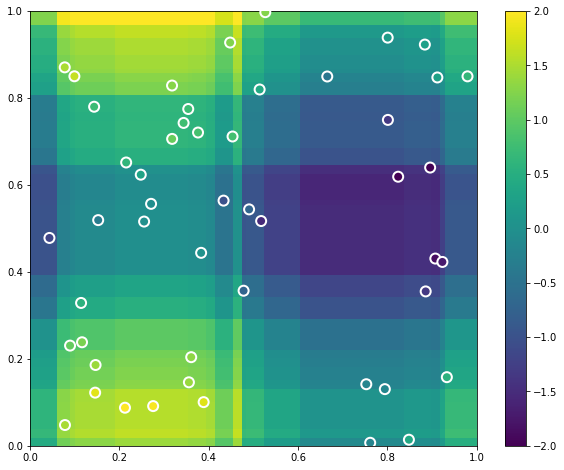

In [25]:
Z = bt.predict(np.array([U.ravel(), V.ravel()]).T)
Z = Z.reshape(U.shape)

fig, ax = plt.subplots(figsize = (10,8))

plt.pcolor(U, V, Z, vmin = -2, vmax = 2)
plt.colorbar()

cm = plt.get_cmap()
plt.scatter(X[:,0], X[:,1], edgecolor = 'white', linewidth = 2,
            s = 100, c = y, cmap = cm, zorder = 100);

If we compare to our bootstrap aggregate trees from before, we get a significant improvement from boosting.

## Boosted Decision Trees on the King County Housing Dataset

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [3]:
kc = pd.read_csv('train.csv')

X = kc[['phi',
 's',
 'tau',
 'Fss_1',
 'Fss_2',
 'Fss_3',
 'Fss_4',
 'Fss_5',
 'Fss_6',
 'Fss_7',
 'Fss_8',
 'Fss_9',
 'Fss_10',
 'Fss_11',
 'Fss_12',
 'Fss_13',
 'Fss_14',
 'Fss_15',
 'Fss_16',
 'Fss_17',
 'Fss_18',
 'Fss_19',
 'Fss_20',
 'Fss_21',
 'Fss_22',
 'Fss_23',
 'Fss_24',
 'Fss_25',
 'Fss_26',
 'Fss_27',
 'Fss_28',
 'Fss_29',
 'Fss_30',
 'Fss_31',
 'Fss_32',
 'Fss_33',
 'Fss_34',
 'Fss_35',
 'Fss_36',
 'Fss_37',
 'Fss_38',
 'Fss_39',
 'Fss_40',
 'Fss_41',
 'Fss_42',
 'Fss_43',
 'Fss_44',
 'Fss_45',
 'Fss_46',
 'Fss_47',
 'Fss_48',
 'Fss_49',
 'Fss_50',
 'Fss_51',
 'Fss_52',
 'Fss_53',
 'Fss_54',
 'Fss_55',
 'Fss_56',
 'Fss_57',
 'Fss_58',
 'Fss_59',
 'Fss_60',
 'Fss_61',
 'Fss_62',
 'Fss_63',
 'Fss_64',
 'Fss_65',
 'Fss_66',
 'Fss_67',
 'Fss_68',
 'Fss_69',
 'Fss_70',
 'Fss_71',
 'Fss_72',
 'Fss_73',
 'Fss_74',
 'Fss_75',
 'Fss_76',
 'Fss_77',
 'Fss_78',
 'Fss_79',
 'Fss_80',
 'Fss_81',
 'Fss_82',
 'Fss_83',
 'Fss_84',
 'Fss_85',
 'Fss_86',
 'Fss_87',
 'Fss_88',
 'Fss_89',
 'Fss_90',
 'Fss_91',
 'Fss_92',
 'Fss_93',
 'Fss_94',
 'Fss_95',
 'Fss_96',
 'Fsv_1',
 'Fsv_2',
 'Fsv_3',
 'Fsv_4',
 'Fsv_5',
 'Fsv_6',
 'Fsv_7',
 'Fsv_8',
 'Fsv_9',
 'Fsv_10',
 'Fsv_11',
 'Fsv_12',
 'Fsv_13',
 'Fsv_14',
 'Fsv_15',
 'Fsv_16',
 'Fsv_17',
 'Fsv_18',
 'Fsv_19',
 'Fsv_20',
 'Fsv_21',
 'Fsv_22',
 'Fsv_23',
 'Fsv_24',
 'Fsv_25',
 'Fsv_26',
 'Fsv_27',
 'Fsv_28',
 'Fsv_29',
 'Fsv_30',
 'Fsv_31',
 'Fsv_32',
 'Fsv_33',
 'Fsv_34',
 'Fsv_35',
 'Fsv_36',
 'Fsv_37',
 'Fsv_38',
 'Fsv_39',
 'Fsv_40',
 'Fsv_41',
 'Fsv_42',
 'Fsv_43',
 'Fsv_44',
 'Fsv_45',
 'Fsv_46',
 'Fsv_47',
 'Fsv_48',
 'Fsv_49',
 'Fsv_50',
 'Fsv_51',
 'Fsv_52',
 'Fsv_53',
 'Fsv_54',
 'Fsv_55',
 'Fsv_56',
 'Fsv_57',
 'Fsv_58',
 'Fsv_59',
 'Fsv_60',
 'Fsv_61',
 'Fsv_62',
 'Fsv_63',
 'Fsv_64',
 'Fsv_65',
 'Fsv_66',
 'Fsv_67',
 'Fsv_68',
 'Fsv_69',
 'Fsv_70',
 'Fsv_71',
 'Fsv_72',
 'Fsv_73',
 'Fsv_74',
 'Fsv_75',
 'Fsv_76',
 'Fsv_77',
 'Fsv_78',
 'Fsv_79',
 'Fsv_80',
 'Fsv_81',
 'Fsv_82',
 'Fsv_83',
 'Fsv_84',
 'Fsv_85',
 'Fsv_86',
 'Fsv_87',
 'Fsv_88',
 'Fsv_89',
 'Fsv_90',
 'Fsv_91',
 'Fsv_92',
 'Fsv_93',
 'Fsv_94',
 'Fsv_95',
 'Fsv_96',
 'Fvv_1',
 'Fvv_2',
 'Fvv_3',
 'Fvv_4',
 'Fvv_5',
 'Fvv_6',
 'Fvv_7',
 'Fvv_8',
 'Fvv_9',
 'Fvv_10',
 'Fvv_11',
 'Fvv_12',
 'Fvv_13',
 'Fvv_14',
 'Fvv_15',
 'Fvv_16',
 'Fvv_17',
 'Fvv_18',
 'Fvv_19',
 'Fvv_20',
 'Fvv_21',
 'Fvv_22',
 'Fvv_23',
 'Fvv_24',
 'Fvv_25',
 'Fvv_26',
 'Fvv_27',
 'Fvv_28',
 'Fvv_29',
 'Fvv_30',
 'Fvv_31',
 'Fvv_32',
 'Fvv_33',
 'Fvv_34',
 'Fvv_35',
 'Fvv_36',
 'Fvv_37',
 'Fvv_38',
 'Fvv_39',
 'Fvv_40',
 'Fvv_41',
 'Fvv_42',
 'Fvv_43',
 'Fvv_44',
 'Fvv_45',
 'Fvv_46',
 'Fvv_47',
 'Fvv_48',
 'Fvv_49',
 'Fvv_50',
 'Fvv_51',
 'Fvv_52',
 'Fvv_53',
 'Fvv_54',
 'Fvv_55',
 'Fvv_56',
 'Fvv_57',
 'Fvv_58',
 'Fvv_59',
 'Fvv_60',
 'Fvv_61',
 'Fvv_62',
 'Fvv_63',
 'Fvv_64',
 'Fvv_65',
 'Fvv_66',
 'Fvv_67',
 'Fvv_68',
 'Fvv_69',
 'Fvv_70',
 'Fvv_71',
 'Fvv_72',
 'Fvv_73',
 'Fvv_74',
 'Fvv_75',
 'Fvv_76',
 'Fvv_77',
 'Fvv_78',
 'Fvv_79',
 'Fvv_80',
 'Fvv_81',
 'Fvv_82',
 'Fvv_83',
 'Fvv_84',
 'Fvv_85',
 'Fvv_86',
 'Fvv_87',
 'Fvv_88',
 'Fvv_89',
 'Fvv_90',
 'Fvv_91',
 'Fvv_92',
 'Fvv_93',
 'Fvv_94',
 'Fvv_95',
 'Fvv_96']]
y = kc['permeability']

NameError: name 'X' is not defined

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321)

In [7]:
bt = BoostedTreeRegressor(num_trees = 100).fit(X_train.values, y_train.values)

In [8]:
y_pred = bt.predict(X_test.values)

In [9]:
np.sqrt(mean_squared_error(y_test, y_pred))

2.8367367997294086

In [10]:
mean_absolute_error(y_test, y_pred)

1.5193721940861014

In [11]:
mean_squared_error(y_test, y_pred)

8.047075670939048

In [12]:
bt = BoostedTreeRegressor(num_trees = 1000).fit(X_train.values, y_train.values)

In [14]:
y_pred = bt.predict(X_test.values)

In [15]:
mean_squared_error(y_test, y_pred)

1.6193751234065328

In [16]:
mean_absolute_error(y_test, y_pred)

0.6131613558760736

Our (super simple) decision tree booster does not do as well as other models we have tried. Let's look at a couple of other implementations of gradient boosing.

First, scikit-learn's implementation.

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

In [17]:
gbr = GradientBoostingRegressor().fit(X_train, y_train)

In [18]:
mean_absolute_error(y_test, gbr.predict(X_test))

0.47121924226715567

In [22]:
gbr = GradientBoostingRegressor(n_estimators = 1000).fit(X_train, y_train)

In [24]:
mean_absolute_error(y_test, gbr.predict(X_test))

0.4019306884995516

In [23]:
mean_squared_error(y_test, gbr.predict(X_test))

1.2034145310742232

This class also provides feature importances.

In [25]:
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': gbr.feature_importances_})

In [26]:
feature_importances.sort_values('importance', ascending = False).head(20)

,feature,importance
204,Fvv_10,0.097694
205,Fvv_11,0.085885
207,Fvv_13,0.085119
3,Fss_1,0.075814
209,Fvv_15,0.070369
206,Fvv_12,0.070179
208,Fvv_14,0.058594
99,Fsv_1,0.049453
1,s,0.048540
203,Fvv_9,0.029676


Finally, there are other implementation of gradient boosting available with various improvements such as allowing for regularization. See, for example, [catboost](https://catboost.ai/), [lightgbm](https://lightgbm.readthedocs.io/en/latest/) and [xgboost](https://xgboost.readthedocs.io/en/latest/).